# Text Sentiment Classification

In [16]:
import numpy as np
from tensorflow import keras
import os
import tarfile
from d2l.tensorflow.data import Vocab, batch_iter
from d2l.tensorflow.plot import plot_history

##  Reading Data

In [2]:
fname = '../data/aclImdb_v1.tar.gz'
data_dir = '../data/'
with tarfile.open(fname, 'r') as f:
    f.extractall(data_dir)

In [3]:
def read_imdb(folder='train'):
    data, labels = [], []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_dir, 'aclImdb', folder, label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data, test_data = read_imdb('train'), read_imdb('test')
print('# trainings:', len(train_data[0]), '\n# tests:', len(test_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000 
# tests: 25000
label: 1 review: I'm not quite sure if the term "serious comedy" applies to t
label: 1 review: I saw this film in Winnipeg recently - appropriate, given th
label: 1 review: I have read the short story by Norman Maclean, and the movie


## Tokenization and Vocabulary 



In [4]:
def tokenize(sentences):
    return [line.split(' ') for line in sentences]

train_tokens = tokenize(train_data[0])
test_tokens = tokenize(test_data[0])

vocab = Vocab([tk for line in train_tokens for tk in line], min_freq=5)

## Padding to the Same Length


In [5]:
max_len = 500

def pad(x):
    if len(x) > max_len:        
        return x[:max_len]
    else:
        return x + [vocab.unk] * (max_len - len(x))
    
train_features = np.array([pad(vocab[line]) for line in train_tokens])
test_features = np.array([pad(vocab[line]) for line in test_tokens])

### Create Data Iterator

In [6]:
batch_size = 64

train_steps = len(train_features) // batch_size
test_steps = len(test_features) // batch_size

train_iter = batch_iter(train_features, train_data[1], batch_size)
test_iter = batch_iter(test_features, test_data[1], batch_size)

In [7]:
for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break

X (64, 500) y (64,)


## Use a Bidirectional LSTM Model

In [8]:
vocab_size, embed_size, num_hiddens, num_layers = len(vocab), 50, 100, 2

In [9]:
model = keras.models.Sequential()

model.add(keras.layers.Embedding(vocab_size, embed_size))

for i in range(num_layers - 1):
    model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(num_hiddens, return_sequences=True))
    )
model.add(keras.layers.Bidirectional(keras.layers.LSTM(num_hiddens)))

model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Load Pre-trained Word Vectors


In [10]:
embedding_vector = {}

with open('../data/glove.6B.50d.txt', 'r') as f:
    for line in f:
        value = line.split(' ')
        word = value[0]
        coef = np.array(value[1:], dtype=np.float32)
        embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size, embed_size))

for word, i in vocab.token_to_idx.items():
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

In [11]:
embedding_matrix.shape

(49339, 50)

In [12]:
model.layers[0].weights[0][0:2]

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.01607968, -0.02547954, -0.01860879,  0.01312736,  0.03725201,
        -0.0097711 ,  0.04376687, -0.00995807, -0.02740082, -0.03994985,
         0.04826045, -0.00716128, -0.01385297,  0.03531832, -0.02821181,
         0.04814849,  0.04070887,  0.04969727,  0.026465  , -0.03028735,
        -0.01121533,  0.02885708, -0.00807704, -0.01906406,  0.02350641,
         0.01992896, -0.02824267,  0.0382483 , -0.0202284 , -0.01312544,
         0.04681995,  0.0022816 , -0.00430968, -0.04447986,  0.04180825,
         0.02690541, -0.04074479,  0.00569285, -0.01472883, -0.03478103,
        -0.01400789,  0.01722432,  0.02076365, -0.0467458 , -0.04429125,
        -0.02636979, -0.04480354, -0.01723791,  0.0056163 ,  0.03571469],
       [ 0.0311061 ,  0.00401275, -0.03498906,  0.00681442,  0.02598459,
        -0.00753953, -0.04394938, -0.02246018, -0.0238169 , -0.01415907,
        -0.00945063,  0.03189019,  0.01821974, -0.04427066, -0.00289028,
 

In [13]:
model.layers[0].set_weights([embedding_matrix])

In [14]:
model.layers[0].weights[0][0:2]

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
 

## Train and Evaluate the Model



In [15]:
num_epochs = 5
hist = model.fit(
    train_iter, steps_per_epoch=train_steps, 
    validation_data=test_iter, validation_steps=test_steps,
    epochs=5
)

Epoch 1/5
390/390 [==============================] - 91s 234ms/step - loss: 0.6252 - accuracy: 0.6490 - val_loss: 0.6759 - val_accuracy: 0.5796
Epoch 2/5
390/390 [==============================] - 92s 235ms/step - loss: 0.5627 - accuracy: 0.7087 - val_loss: 0.5460 - val_accuracy: 0.7374
Epoch 3/5
390/390 [==============================] - 91s 234ms/step - loss: 0.4745 - accuracy: 0.7768 - val_loss: 0.4321 - val_accuracy: 0.8050
Epoch 4/5
390/390 [==============================] - 91s 233ms/step - loss: 0.2941 - accuracy: 0.8805 - val_loss: 0.3669 - val_accuracy: 0.8546
Epoch 5/5
390/390 [==============================] - 91s 233ms/step - loss: 0.1529 - accuracy: 0.9461 - val_loss: 0.4899 - val_accuracy: 0.8311


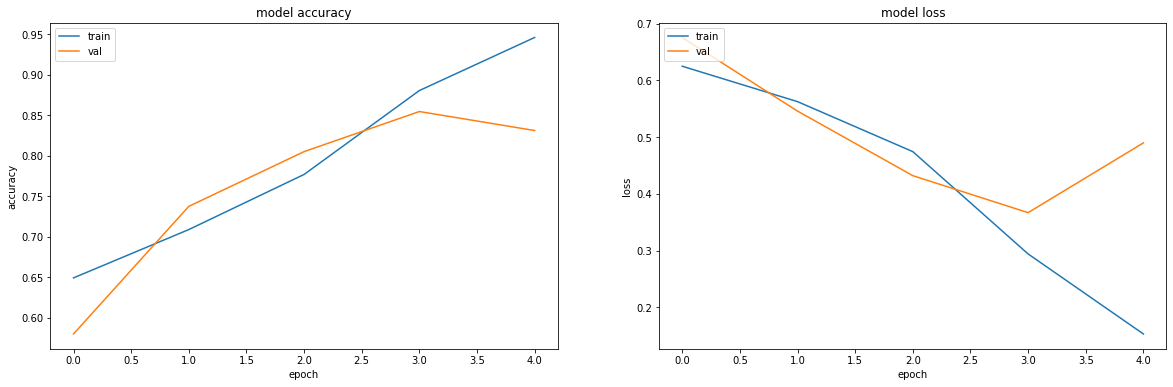

In [17]:
plot_history(hist, 'accuracy')

## Predict sencences

In [18]:
def predict_sentiment(net, vocab, sentence):
    sentence = np.array(vocab[sentence.split()])
    label = np.argmax(net(sentence.reshape((1, -1))), axis=1)
    return 'positive' if label == 1 else 'negative'

In [20]:
predict_sentiment(model, vocab, 'this movie is so great')

'positive'

In [21]:
predict_sentiment(model, vocab, 'this movie is so bad')

'negative'